# Modeling using Regression

---

This notebook explores using Regression to predict the continuous variable of monthly **Oil (bbl/d) Total production** for a given Region in a given month, provided Nightfire-based Predictor Features (X Features). It will explore using Linear Regression, how and why it fails, as well as Tree-based Regression. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling-using-Regression" data-toc-modified-id="Modeling-using-Regression-1">Modeling using Regression</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1">Imports</a></span></li><li><span><a href="#Train,-Test-Split" data-toc-modified-id="Train,-Test-Split-1.2">Train, Test Split</a></span></li><li><span><a href="#Linear-Regression-All-EIA-Basin-Regions" data-toc-modified-id="Linear-Regression-All-EIA-Basin-Regions-1.3">Linear Regression All EIA Basin Regions</a></span><ul class="toc-item"><li><span><a href="#Model-Instantiation-and-Fit" data-toc-modified-id="Model-Instantiation-and-Fit-1.3.1">Model Instantiation and Fit</a></span></li></ul></li><li><span><a href="#Linear-Regression-Individual-Regions" data-toc-modified-id="Linear-Regression-Individual-Regions-1.4">Linear Regression Individual Regions</a></span><ul class="toc-item"><li><span><a href="#Model-Instantiation-and-Fit" data-toc-modified-id="Model-Instantiation-and-Fit-1.4.1">Model Instantiation and Fit</a></span></li></ul></li><li><span><a href="#Decision-Tree-Regressor--All-EIA-Basin-Regions" data-toc-modified-id="Decision-Tree-Regressor--All-EIA-Basin-Regions-1.5"><a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html" target="_blank">Decision Tree Regressor</a>  All EIA Basin Regions</a></span><ul class="toc-item"><li><span><a href="#Model-Instantiation-and-Fit" data-toc-modified-id="Model-Instantiation-and-Fit-1.5.1">Model Instantiation and Fit</a></span></li></ul></li><li><span><a href="#Random-Forest-Regressor--All-EIA-Basin-Regions" data-toc-modified-id="Random-Forest-Regressor--All-EIA-Basin-Regions-1.6"><a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html" target="_blank">Random Forest Regressor</a>  All EIA Basin Regions</a></span><ul class="toc-item"><li><span><a href="#Model-Instantiation-and-Fit" data-toc-modified-id="Model-Instantiation-and-Fit-1.6.1">Model Instantiation and Fit</a></span></li></ul></li><li><span><a href="#Extra-Trees-Regressor-All-EIA-Basin-Regions" data-toc-modified-id="Extra-Trees-Regressor-All-EIA-Basin-Regions-1.7"><a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html" target="_blank">Extra Trees Regressor</a> All EIA Basin Regions</a></span><ul class="toc-item"><li><span><a href="#Model-Instantiation-and-Fit" data-toc-modified-id="Model-Instantiation-and-Fit-1.7.1">Model Instantiation and Fit</a></span></li><li><span><a href="#Satisfactory-Results" data-toc-modified-id="Satisfactory-Results-1.7.2">Satisfactory Results</a></span></li></ul></li><li><span><a href="#Interpretation" data-toc-modified-id="Interpretation-1.8">Interpretation</a></span><ul class="toc-item"><li><span><a href="#Normality-of-Residuals" data-toc-modified-id="Normality-of-Residuals-1.8.1">Normality of Residuals</a></span></li><li><span><a href="#Predictions-vs.-Observed-Plot" data-toc-modified-id="Predictions-vs.-Observed-Plot-1.8.2">Predictions vs. Observed Plot</a></span></li><li><span><a href="#Residuals-Plot" data-toc-modified-id="Residuals-Plot-1.8.3">Residuals Plot</a></span></li><li><span><a href="#Predictions-vs.-Observed-Oil-Production-Over-Time-for-All-Regions" data-toc-modified-id="Predictions-vs.-Observed-Oil-Production-Over-Time-for-All-Regions-1.8.4">Predictions vs. Observed Oil Production Over Time for All Regions</a></span></li><li><span><a href="#Predictions-vs.-Observed-Oil-Production-Over-Time-for-Individual-Regions" data-toc-modified-id="Predictions-vs.-Observed-Oil-Production-Over-Time-for-Individual-Regions-1.8.5">Predictions vs. Observed Oil Production Over Time for Individual Regions</a></span></li></ul></li></ul></li><li><span><a href="#Next-Notebook" data-toc-modified-id="Next-Notebook-2">Next Notebook</a></span></li></ul></div>

## Imports

In [97]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
import numpy as np
import datetime as dt
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.ticker as mtick

In [99]:
from tools.tools import read_json, get_current_time

In [100]:
plt.style.use('ggplot')

In [101]:
basin_colors_hex = {  # manually defined dictionary of EIA basin-level standardized colors 
    "Anadarko Region":    "#2BA2CF", 
    "Appalachia Region":  "#769F5D",
    "Bakken Region":      "#F6C432", 
    "Eagle Ford Region":  "#48366B", 
    "Haynesville Region": "#807B8F",
    "Niobrara Region":    "#9D3341",
    "Permian Region":     "#6F4B27",
}

In [102]:
config = read_json('../capstone/config.json')

current_date = get_current_time('yyyymmdd')

wd = f"{config['workspace_directory']}/data"

In [103]:
df = pd.read_csv(f"{wd}/processing/basin_int_viirs_for_modeling.csv")

In [104]:
region_list = list(df['region'].unique())

In [105]:
df.head(3)

,year_month,region,latest_day_in_month,obs_day_cnt_avg,obs_day_cnt_med,obs_day_cnt_sum,obs_day_cnt_min,obs_day_cnt_max,qf_fit_day_avg_avg,qf_fit_day_avg_med,...,obs_day_cnt_avg_over_pct_month_completed,obs_day_cnt_med_over_pct_month_completed,obs_day_cnt_sum_over_pct_month_completed,obs_day_cnt_min_over_pct_month_completed,obs_day_cnt_max_over_pct_month_completed,obs_day_cnt_avg_per_squaremeters_over_pct_month_completed,obs_day_cnt_med_per_squaremeters_over_pct_month_completed,obs_day_cnt_sum_per_squaremeters_over_pct_month_completed,obs_day_cnt_min_per_squaremeters_over_pct_month_completed,obs_day_cnt_max_per_squaremeters_over_pct_month_completed
0,2012-03-01,Anadarko Region,2012-03-31,13.041667,12.5,313,3,33,4.786164,4.291667,...,13.041667,12.5,313.0,3.0,33.0,1.728202e-10,1.656423e-10,4.147684e-09,3.975416e-11,4.372958e-10
1,2012-03-01,Appalachia Region,2012-03-31,31.071429,32.0,870,1,86,9.502222,8.966184,...,31.071429,32.0,870.0,1.0,86.0,1.616772e-10,1.665089e-10,4.526961e-09,5.203404e-12,4.474927e-10
2,2012-03-01,Bakken Region,2012-03-31,260.321429,249.0,7289,2,571,1.497039,1.500962,...,260.321429,249.0,7289.0,2.0,571.0,2.852491e-09,2.728436e-09,7.986976e-08,2.191515e-11,6.256775e-09


In [106]:
df.shape

(679, 84)

## Train, Test Split

In [107]:
X = df.drop(columns=[
    'oil_bbl_d_total_production',
    'latest_day_in_month',
    'last_day_of_month',
    'first_day_of_month',
    'year_month',
])

X = pd.get_dummies(X)

y = df['oil_bbl_d_total_production']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.25,
    random_state=42,
)

In [108]:
X_train.shape

(509, 85)

In [109]:
for i in X.columns:
    print(i)  # check the columns putting into the model. 

obs_day_cnt_avg
obs_day_cnt_med
obs_day_cnt_sum
obs_day_cnt_min
obs_day_cnt_max
qf_fit_day_avg_avg
qf_fit_day_avg_med
qf_fit_day_avg_sum
qf_fit_day_avg_min
qf_fit_day_avg_max
qf_fit_day_med_avg
qf_fit_day_med_med
qf_fit_day_med_sum
qf_fit_day_med_min
qf_fit_day_med_max
qf_fit_day_sum_avg
qf_fit_day_sum_med
qf_fit_day_sum_sum
qf_fit_day_sum_min
qf_fit_day_sum_max
qf_fit_day_min_avg
qf_fit_day_min_med
qf_fit_day_min_sum
qf_fit_day_min_min
qf_fit_day_min_max
qf_fit_day_max_avg
qf_fit_day_max_med
qf_fit_day_max_sum
qf_fit_day_max_min
qf_fit_day_max_max
aland
obs_day_cnt_avg_per_squaremeters
obs_day_cnt_med_per_squaremeters
obs_day_cnt_sum_per_squaremeters
obs_day_cnt_min_per_squaremeters
obs_day_cnt_max_per_squaremeters
qf_fit_day_avg_avg_per_squaremeters
qf_fit_day_avg_med_per_squaremeters
qf_fit_day_avg_sum_per_squaremeters
qf_fit_day_avg_min_per_squaremeters
qf_fit_day_avg_max_per_squaremeters
qf_fit_day_med_avg_per_squaremeters
qf_fit_day_med_med_per_squaremeters
qf_fit_day_med_sum_per

In [110]:
X_test.shape

(170, 85)

## Linear Regression All EIA Basin Regions

### Model Instantiation and Fit

In [111]:
lr = LinearRegression()
lr.fit(X_train, y_train);

In [112]:
lr.score(X_train, y_train)

0.9292579447803779

In [113]:
lr.score(X_test, y_test)  # this is really bad, likely b/c non-similar relationships across regions. 

-10.434339323426029

In [114]:
cross_val_score(lr, X, y, cv=10).mean()

-2.741165656395261

In [115]:
# Not good test score or cross val. Linear Regression does terribly. 
# Next try for individual regions. 

## Linear Regression Individual Regions

### Model Instantiation and Fit

In [116]:
# try for linear regression on each individual region. 

region_lr_dict = {}
for region in region_list:
    df_select = df[df['region'] == region]

    X_lr = df_select.drop(columns=[
        'oil_bbl_d_total_production',
        'latest_day_in_month',
        'last_day_of_month',
        'first_day_of_month',
        'year_month',
    ])

    X_lr = pd.get_dummies(X_lr)

    y_lr = df_select['oil_bbl_d_total_production']

    X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
        X_lr, 
        y_lr, 
        random_state=42, 
        test_size=0.25,
    )

    lr = LinearRegression()
    lr.fit(X_train_lr, y_train_lr);

    train_score_lr = lr.score(X_train_lr, y_train_lr)

    test_score_lr = lr.score(X_test_lr, y_test_lr)
    
    cross_val_score_lr = cross_val_score(lr, X_lr, y_lr, cv=2).mean()
    
    region_lr_dict[region] = {
        "Train Score:": train_score_lr,
        "Test Score:": test_score_lr,
        "Cross Validation:": cross_val_score_lr,
        "model": lr,
    }
    
    print(
        region,
        "Train Score:", round(train_score_lr, 4),
        "Test Score:", round(test_score_lr, 4),
        #"Cross Validation:", round(cross_val_score_lr, 4),
    ) 

Anadarko Region Train Score: 0.9364 Test Score: 0.6745
Appalachia Region Train Score: 0.9191 Test Score: 0.6295
Bakken Region Train Score: 0.8678 Test Score: 0.6975
Eagle Ford Region Train Score: 0.78 Test Score: 0.3154
Haynesville Region Train Score: 0.9087 Test Score: 0.3912
Niobrara Region Train Score: 0.9681 Test Score: -0.7017
Permian Region Train Score: 0.9924 Test Score: 0.9682


In [117]:
# These scores are not great either. Next was to investigate Tree-based Regression. 

## [Decision Tree Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)  All EIA Basin Regions


### Model Instantiation and Fit

In [118]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train);

In [119]:
dt.score(X_train, y_train)  # r-squared score on train

1.0

In [120]:
dt.score(X_test, y_test)  # fairly good score for decision trees on the test

0.9914035901602286

In [121]:
cross_val_score(dt, X, y, cv=10).mean()  # promising cross validatation

0.9264122690921491

In [122]:
important_features = pd.Series(data=dt.feature_importances_,index=X.columns)
important_features.sort_values(ascending=False,inplace=True)
important_features.head(20)  # decision tree regression feature importances

region_Permian Region                       0.558261
latest_day_in_month_epochtime               0.197155
obs_day_cnt_avg                             0.182422
last_day_of_month_epochtime                 0.013895
qf_fit_day_avg_avg                          0.013088
epochtime                                   0.013027
region_Niobrara Region                      0.004139
region_Haynesville Region                   0.003630
first_day_of_month_epochtime                0.002943
aland                                       0.002521
region_Anadarko Region                      0.002241
obs_day_cnt_max                             0.001509
obs_day_cnt_med                             0.001332
qf_fit_day_med_sum                          0.001033
region_Appalachia Region                    0.000584
obs_day_cnt_max_over_pct_month_completed    0.000397
qf_fit_day_sum_max                          0.000343
qf_fit_day_avg_med                          0.000310
qf_fit_day_avg_max                          0.

## [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)  All EIA Basin Regions


### Model Instantiation and Fit

In [123]:
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train);

In [124]:
rf.score(X_train, y_train)  # r-squared score 

0.9988622701995103

In [125]:
rf.score(X_test, y_test)  # r-squared score 

0.994414269757453

In [126]:
cross_val_score(rf, X, y, cv=10).mean()

0.9377664128868659

In [127]:
important_features = pd.Series(data=rf.feature_importances_,index=X.columns)
important_features.sort_values(ascending=False,inplace=True)
important_features.head(20)  # random forest regression feature importances

region_Permian Region                       0.436975
obs_day_cnt_avg                             0.096925
obs_day_cnt_med                             0.087898
obs_day_cnt_avg_over_pct_month_completed    0.050949
obs_day_cnt_med_over_pct_month_completed    0.046776
latest_day_in_month_epochtime               0.046618
last_day_of_month_epochtime                 0.041670
epochtime                                   0.039598
first_day_of_month_epochtime                0.037313
obs_day_cnt_max_over_pct_month_completed    0.015532
obs_day_cnt_max                             0.015236
qf_fit_day_avg_avg                          0.013287
year                                        0.012786
qf_fit_day_med_med                          0.011516
aland                                       0.008825
qf_fit_day_med_avg                          0.005268
obs_day_cnt_sum_over_pct_month_completed    0.004087
obs_day_cnt_sum                             0.003207
qf_fit_day_med_sum                          0.

## [Extra Trees Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html) All EIA Basin Regions

### Model Instantiation and Fit

In [128]:
et = ExtraTreesRegressor(random_state=42, n_estimators=500)
et.fit(X_train, y_train);

In [129]:
et.score(X_train, y_train)

1.0

In [130]:
et.score(X_test, y_test)  # r-squared score 

0.9986310902336664

In [131]:
cross_val_score(et, X, y, cv=10).mean()  # r-squared score 

0.9705267575098588

In [132]:
important_features = pd.Series(data=et.feature_importances_,index=X.columns)
important_features.sort_values(ascending=False,inplace=True)
important_features.head(20)  # extra trees regression feature importances

region_Permian Region                                        0.558261
qf_fit_day_med_med                                           0.087223
qf_fit_day_med_avg                                           0.042758
obs_day_cnt_sum_per_squaremeters_over_pct_month_completed    0.033484
obs_day_cnt_sum_per_squaremeters                             0.028510
year                                                         0.026053
last_day_of_month_epochtime                                  0.019889
obs_day_cnt_avg                                              0.018417
latest_day_in_month_epochtime                                0.018293
region_Eagle Ford Region                                     0.016568
first_day_of_month_epochtime                                 0.015578
epochtime                                                    0.015536
obs_day_cnt_sum_over_pct_month_completed                     0.014332
obs_day_cnt_avg_over_pct_month_completed                     0.013989
obs_day_cnt_sum     

In [133]:
rmse = sqrt(mean_squared_error(y_test, et.predict(X_test)))
print('Root Mean Squared Error', round(rmse, 4), 'in Oil (bbl/d) Total production')

Root Mean Squared Error 26916.3711 in Oil (bbl/d) Total production


### Satisfactory Results 

A **test score of 0.9982 R-squared score** with a **0.9697 Cross Validation 10 folds scor**e of is interpreted as satisfactory in using Nightfire data aggregated to EIA Basin Region to predict Oil (bbl/d) Total production per month. It does not seem necessary to use grid search or continue with much more analysis here as results here are very promising. 

## Interpretation 

In [134]:
predicted = et.predict(X) #cross_val_predict(et, X, y, cv=10)  # generate predictions

In [135]:
df['colors'] = df['region'].map(basin_colors_hex)  # adding custom colors column for plots

### Normality of Residuals

In [136]:
resids = y - predicted

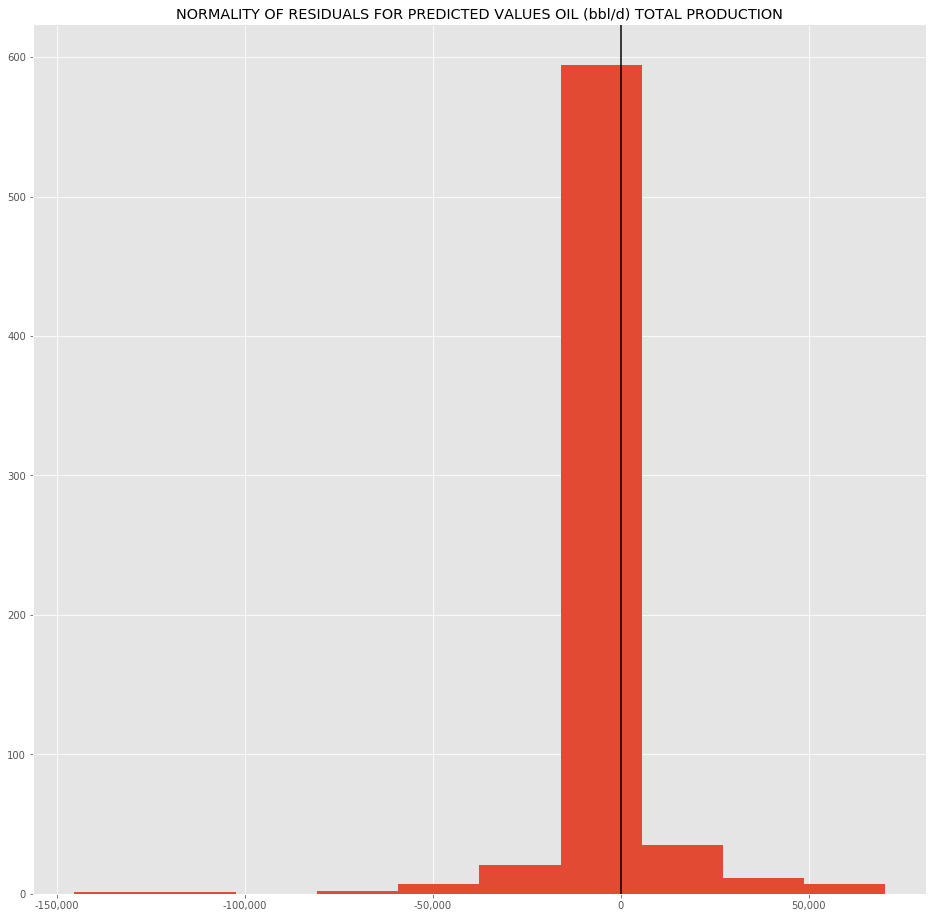

In [137]:
# Normality of residuals assumption
fig, ax = plt.subplots(1, 1, figsize=(16, 16))

plt.hist(resids, bins=10)
plt.axvline(0, color='black');
plt.title('NORMALITY OF RESIDUALS FOR PREDICTED VALUES OIL (bbl/d) TOTAL PRODUCTION')
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
ax.xaxis.set_major_formatter(tick);

plt.savefig(f'../images/extra_trees_residual_normality.png', dpi=300)
plt.show();

### Predictions vs. Observed Plot

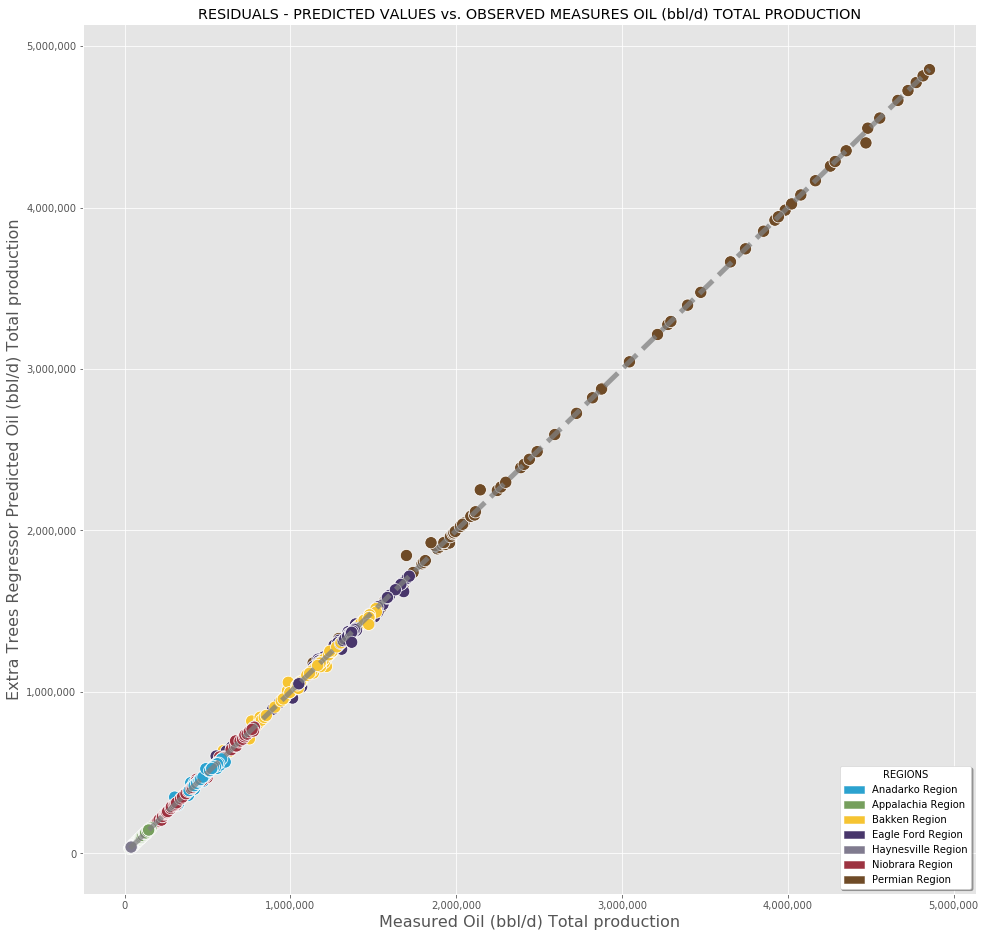

In [138]:
color_labels = df['region'].unique()
legend_patches = []

rgb_values = sns.color_palette("Set2", 7)

color_map = dict(zip(color_labels, rgb_values))

for region in region_list:
    legend_patches.append(mpatches.Patch(color=basin_colors_hex[region], label=region))

fig, ax = plt.subplots(1, 1, figsize=(16, 16))

plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=5, color='gray', alpha=0.75)

plt.scatter(y, predicted, c=df['colors'], edgecolors='white', s=150, alpha=1, linewidths=0.75)

plt.xlabel('Measured Oil (bbl/d) Total production', fontsize=16)
plt.ylabel('Extra Trees Regressor Predicted Oil (bbl/d) Total production', fontsize=16)

fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
ax.xaxis.set_major_formatter(tick) 

plt.legend(
    title='REGIONS', 
    loc=4, 
    shadow=True, 
    facecolor='white', 
    labels=region_list,
    handles=legend_patches
)
plt.title('RESIDUALS - PREDICTED VALUES vs. OBSERVED MEASURES OIL (bbl/d) TOTAL PRODUCTION')

plt.savefig(f'../images/extra_trees_residual_predicted_vs_observed.png', dpi=300)
plt.show();

### Residuals Plot

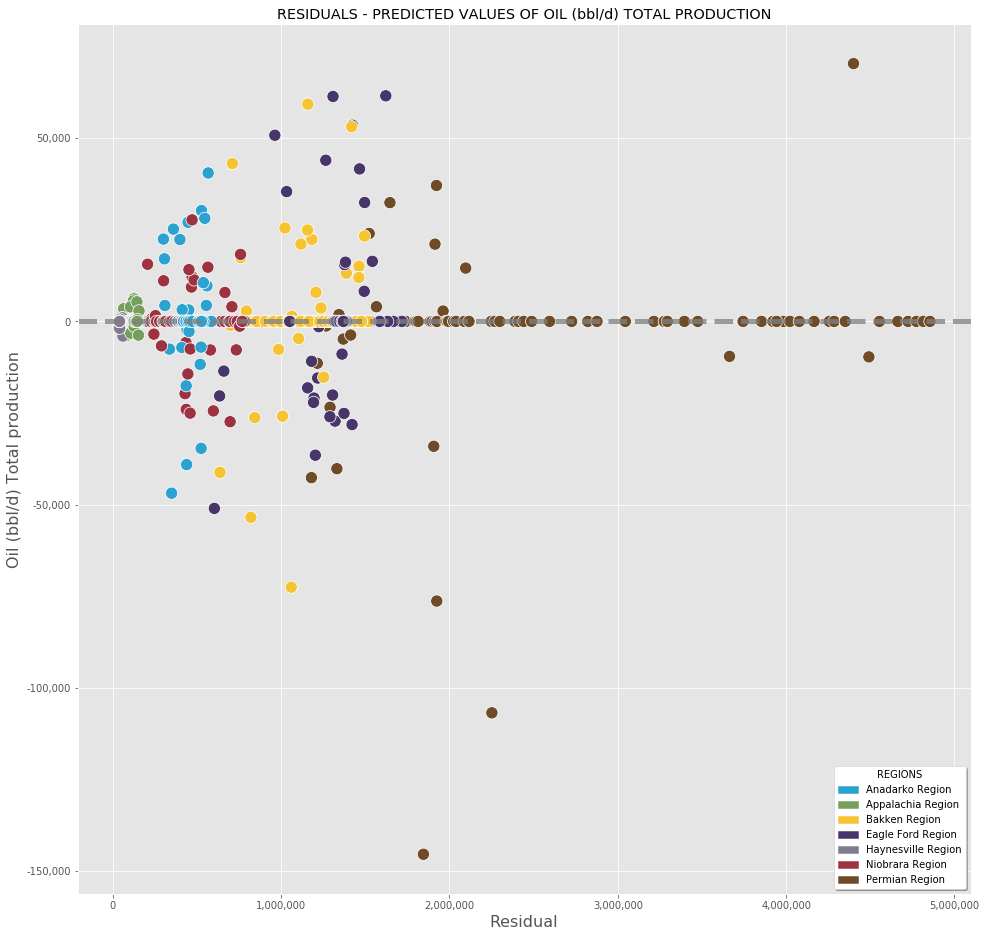

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(16, 16))

fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
ax.xaxis.set_major_formatter(tick) 

plt.axhline(0, lw=5, color='gray', alpha=0.75, linestyle='--')

plt.scatter(predicted, resids, c=df['colors'],  edgecolors='white', s=150, alpha=1, linewidths=0.75)

plt.legend(
    title='REGIONS', 
    loc=4, 
    shadow=True, 
    facecolor='white', 
    labels=region_list,
    handles=legend_patches
)
plt.title('RESIDUALS - PREDICTED VALUES OF OIL (bbl/d) TOTAL PRODUCTION')

plt.xlabel('Residual', fontsize=16)
plt.ylabel('Oil (bbl/d) Total production', fontsize=16)

plt.savefig(f'../images/extra_trees_residuals.png', dpi=300)
plt.show();

In [140]:
df['predicted'] = predicted

In [141]:
df.set_index('year_month', inplace=True)
df.sort_index(inplace=True)  # sort by datetime just to be safe

In [142]:
def eia_variable_plot(df_in, pred_var, actual_var, file_name, legend_loc=2):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    region_list = list(df_in['region'].unique())
    region_list.sort()

    for region in region_list:
        df_pred = df_in[df_in['region'] == region][['region', pred_var, 'colors']]
        df_pred.plot(
            label=region,
            legend=True,
            ax=ax,
            color=df_pred['colors'],
            linewidth=2.5,
            linestyle='dashed',
        )
        
        df_actual = df_in[df_in['region'] == region][['region', actual_var, 'colors']]
        df_actual.plot(
            label=region,
            legend=True,
            ax=ax,
            color=df_actual['colors'],
            linewidth=2.5, 
        )

    fmt = '{x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick) 
    ax.yaxis.set_minor_formatter(tick) 

    ax.set_ylabel("Oil (bbl/d) Total production")
    ax.set_xlabel("")
    
    plt.legend(
        title='REGIONS', 
        loc=legend_loc, 
        shadow=True, 
        facecolor='white', 
        labels=[f'{val} Prediction' if _ == 0 else f'{val} Observed' for val in region_list for _ in (0, 1)],  #region_list,
    )
    plt.title(f"{pred_var.replace('_', ' ').upper()} vs. OBSERVED OIL (bbl/d) TOTAL PRODUCTION")
    
    plt.savefig(f'../images/extra_trees_predictions_{file_name}.png', dpi=300)
    plt.show();

### Predictions vs. Observed Oil Production Over Time for All Regions

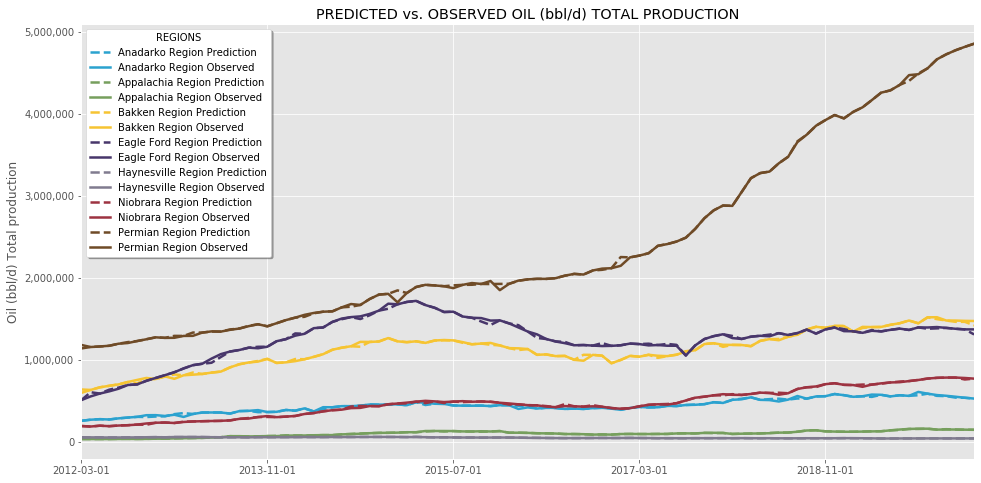

In [143]:
pred_var = 'predicted'
actual_var = 'oil_bbl_d_total_production'
eia_variable_plot(df, pred_var, actual_var, 'all_regions')

### Predictions vs. Observed Oil Production Over Time for Individual Regions

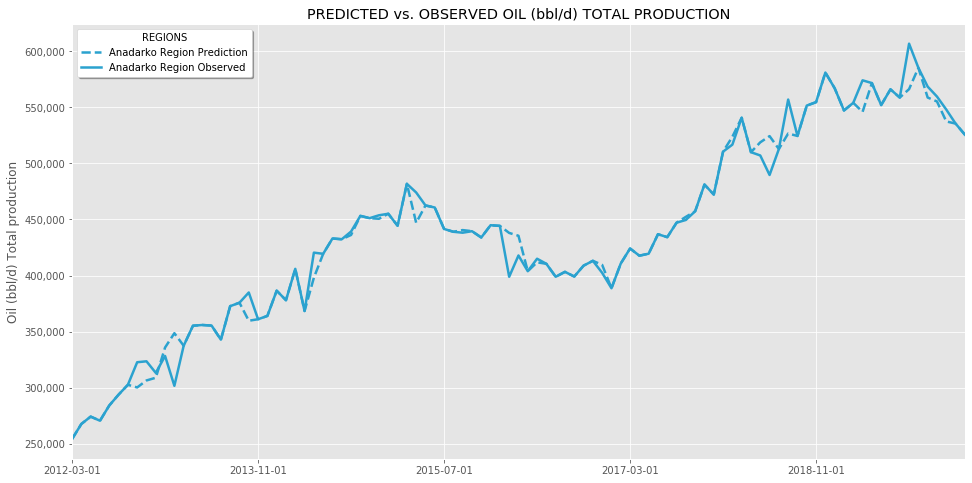

In [144]:
eia_variable_plot(df[df['region'] == 'Anadarko Region'], pred_var, actual_var, 'anadarko_region')

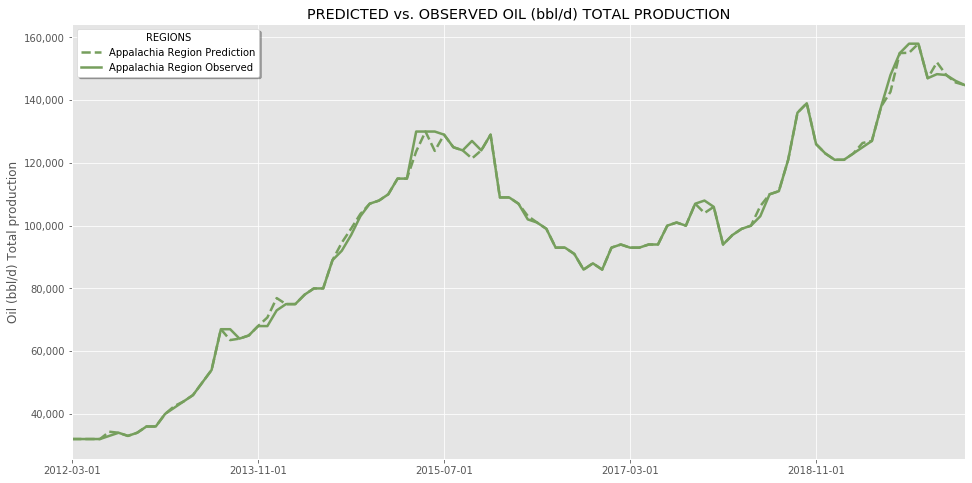

In [145]:
eia_variable_plot(df[df['region'] == 'Appalachia Region'], pred_var, actual_var, 'appalachia_region')

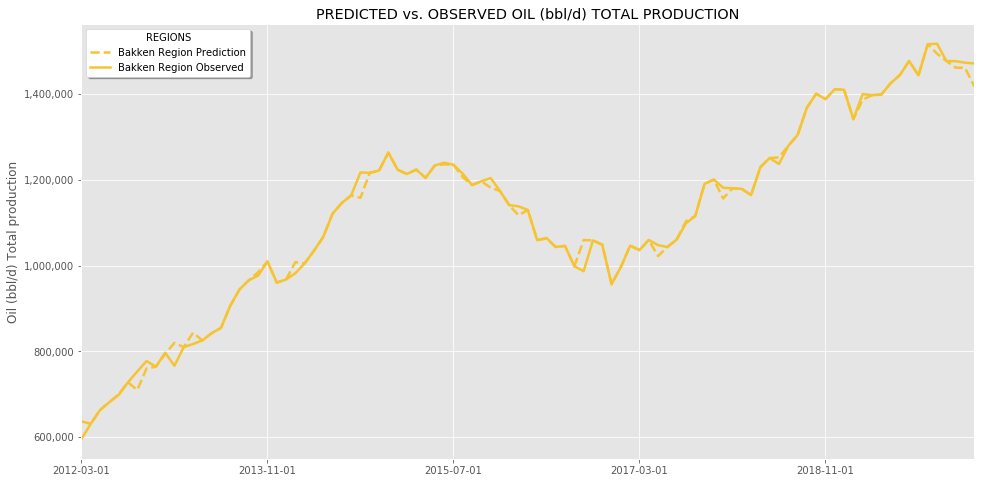

In [146]:
eia_variable_plot(df[df['region'] == "Bakken Region"], pred_var, actual_var, 'bakken_region')

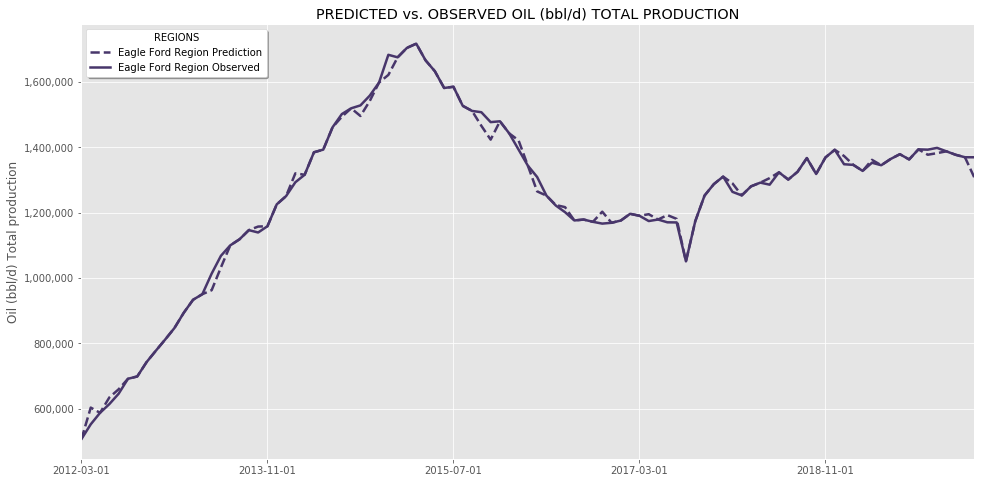

In [147]:
eia_variable_plot(df[df['region'] == "Eagle Ford Region"], pred_var, actual_var, 'eagle_ford_region')

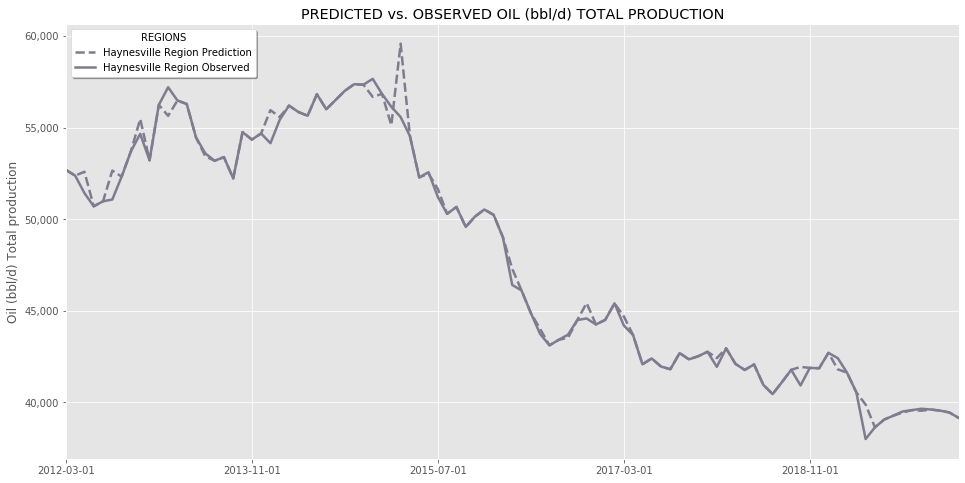

In [148]:
eia_variable_plot(df[df['region'] == "Haynesville Region"], pred_var, actual_var, 'haynesville_region')

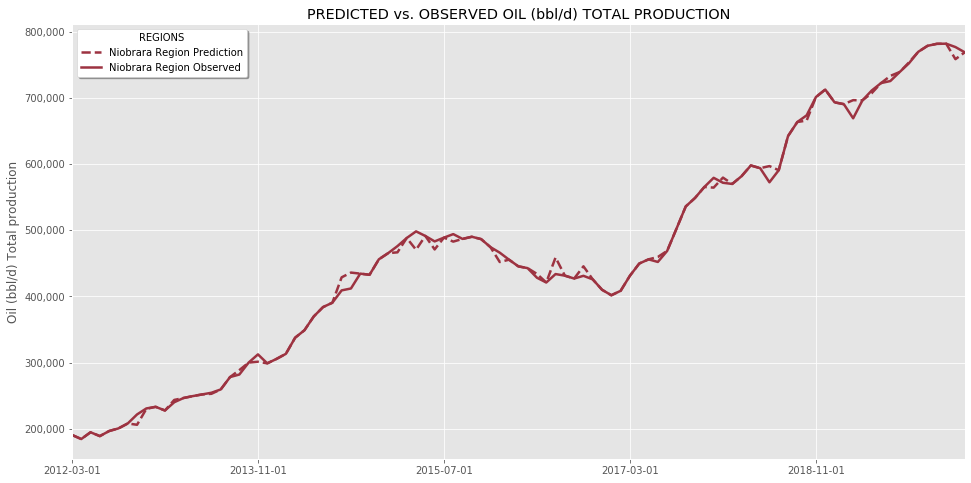

In [149]:
eia_variable_plot(df[df['region'] == "Niobrara Region"], pred_var, actual_var, 'niobrara_region')

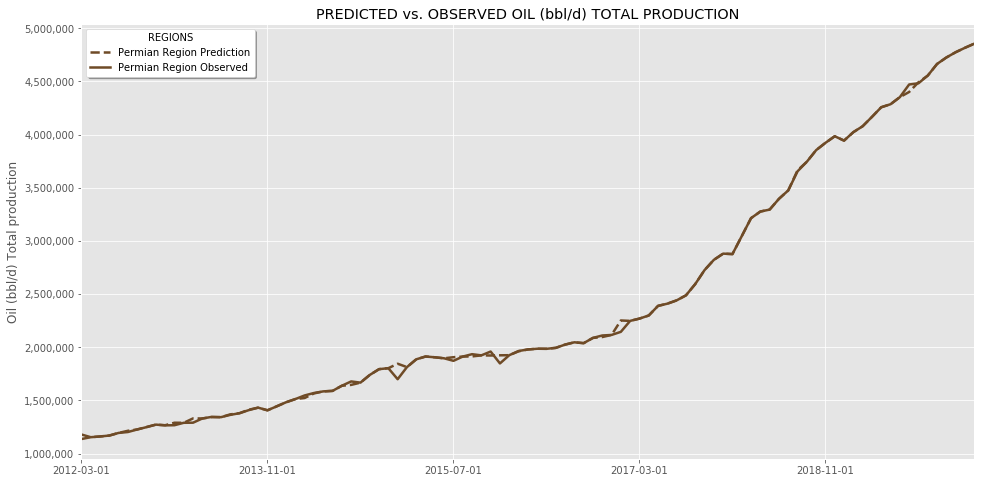

In [150]:
eia_variable_plot(df[df['region'] == "Permian Region"], pred_var, actual_var, 'permian_region')

In [151]:
df.to_csv(f"{wd}/output/basin_extra_trees_predictions.csv", index=True)
# save the predictions to csv

# Next Notebook

[Modeling using Time-Series](https://git.generalassemb.ly/danielmartinsheehan/capstone/blob/master/notebooks/06_modeling_time_series.ipynb)